<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph with Query Understanding and Redis Retrieval Agents using Ollama</b></span>
        <br />
    </div>
    <br />
</div>

# 
 




As we saw in notebook 06, a React agentic approach to search and treating a Redis retriever as a tool, and moreover leaving the reasoning to an LLM could lead to some uncertainty. A react agentic approach might be a better approach for planning in an uncertain situation (maybe a robotic application where parameters of the problem are unknown) and not for a search application where the tasks and steps to take are very well-defined. Any search starts with a query by a user. The first task is to understand the query or user's question. The hardest part is to understand the intent of the user which might need some personalized and contextual understanding of the user - which we will not address here. Nevertheless, the first component of a search application is query understanding. The second component is constructing a refined query via query augmentation, translation of user's query into a combination of target query language and mapping the query into a vector space using an embedding model. After query translation and representation in a vector space, it is time to retrieve the relevant documents. Here we showcase the Redis hybrid search capabilities and its integration in langchain. After fetching the most relevant documents, usually reranking happens (and by reranking we don't necessarily mean Semantic reranking - one could apply business logic in this step; for example, Ad injection and/or reordering based on business and user's context such as location or session information). In this notebook we don't use a reranker but employ a very simple document relevancy checker using the same `llama3` LLM. However, in a more realistic scenario, one should use task-specific or fine-tuned LLMs for each of these steps or even use the existing models or pipelines (query classifier, Learning To Rank, etc.). In fact, it might be a requirement that some models need to run faster/cheaper or be more explainable or certified for complaince reasons (such as Logistic Regression, decision trees, MaxEnt etc.) Please plug in any of such models instead of our generic LLM-based component if needed.      

![Graph](query_understanding_graph.png)

## Environment Setup

In [38]:
import os
import warnings
import dotenv
# mute warnings
warnings.filterwarnings('ignore')
# load env vars from .env file
dotenv.load_dotenv()
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")
print(dir_path)
print(parent_directory)

/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/2_RAG_patterns_with_redis
/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop


### Install Python Dependencies

In [39]:
%%capture
%pip install -r $ROOT_DIR/requirements.txt

### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, this models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2

In [40]:
#setting the local downloaded sentence transformer models folder
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [41]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [42]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

15:23:10 redisvl.index.index INFO   Index already exists, overwriting.


In [43]:
# Skip if you have already done populated your index.
from ingestion import get_sec_data
from ingestion import redis_bulk_upload

sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


In [44]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL','AMZN'])

✅ Loaded 108 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 94 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 103 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 27 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 34 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 28 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 26 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2016-Oct-25-AAPL.tx

## Redis as a Langchain Retriever


In [45]:
from langchain_community.vectorstores import Redis as LangChainRedis
from utils import create_langchain_schemas_from_redis_schema

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [46]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services and technology; product liability; intellectual property ownership and infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, film and digital content; availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.\n\nApple Inc. | 2022 Form 10-K | 13', metadata={'id': 'chunk:AAPL-2022-10K.pdf-763ea067-5c24-4aec-b1fa-0cc6b044d5f3', 'chunk_id': 'AAPL-2022-10K.pdf-763ea067-5c24-4aec-

## Create different components of your Graph pipeline

### RAG Chain
This component is responsible for genereting the final answer given a context we construct using our retrival process 

In [47]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate,PromptTemplate
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

def get_gen_rag_chain():
    # LLM
    gen_llm = ChatOllama(model="llama3", temperature=0)
    gen_local_prompt = PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")

    # Chain
    gen_rag_chain = gen_local_prompt | gen_llm | StrOutputParser()
    return gen_rag_chain

q="what is the deferred apple revenue in 2022?"
context = """As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

my_gen_rag_chain = get_gen_rag_chain()
    # Run Gen LLM
response = my_gen_rag_chain.invoke({"context": context, "question": q})
print(response)

Based on the provided context, I don't know the specific deferred apple revenue for 2022. However, I can tell you that as of September 24, 2022, Apple had total deferred revenue of $12.4 billion.


### Query Understanding
This component is using our basic `llama3` LLM to analyze user's questions and queries and does several tasks in one-shot:
   - determines whether a question is relevant to the domain of finance
   - determines if the question can be answered better by looking into `10k`s or `earning_calls` 
   - determines if the question is generally looking for a numeric answer or an explanation. This could be crucial information in the downstream components where we go to find the right answer or verify our answers. An explanation for example is more textual and it can be measured in terms of cosine similarity;however, a numeric answer can be verified by running a tool that does mathematical calculations that is result of a program, for example in a [PAL chain](https://api.python.langchain.com/en/latest/pal_chain/langchain_experimental.pal_chain.base.PALChain.html#).   

In [48]:
from langchain_core.output_parsers import JsonOutputParser

EARNING_CALL_FIELD = 'earning_call'
FILING_10K_FIELD = 'earning_call'

def get_question_analyzer():
    question_classifier_llm = ChatOllama(model="llama3", format="json", temperature=0)
    question_classifier_prompt = PromptTemplate(
        template=f"""Your task is to analyze and classify a question and formulate a new question related to the topic that you found. You have to determine if the answer for the question can be found in "{EARNING_CALL_FIELD}" or "{FILING_10K_FIELD}" financial filings. So choose either "{EARNING_CALL_FIELD}" or "{FILING_10K_FIELD}" as the assigned class. If you are unsure assign `None`. Assign three classes of '{EARNING_CALL_FIELD}' or '{FILING_10K_FIELD}' or 'None' as a JSON with a single key 'question_class'. Also add a new key called 'new_question' and try to rewrite the given question based on the class you detected. If the detected class is 'None' or your could find a relevance of the questions to those '{EARNING_CALL_FIELD}' or '{FILING_10K_FIELD}' return 'None' as the new question.
          
        
        Also add a new field in the JSON called 'question_type'. You have to determine if the answer to user's question is likely to be a number or an explanation. if the answer to the question is likely to be number assign 'numeric' and if the answer is likely to be explanation assign `explain` to the 'question_type'.
        
       Also add a new field in the JSON called 'question_relevancy'. You have to determine if user's question is relevant to the domain of finance or not.If the question is is not relevant to the domain of finance give the value of 'not_relevant' and if it is relevant to the domain of finance give the value of 'relevant'.    
        
        Only return a valid JSON objects as your response. If you have new information or notes, add a new field in the JSON called `note` and add your explanation in that `note` field.: \n\n {question}.  \n """,
        input_variables=["question"],
    )
    question_analyzer = question_classifier_prompt | question_classifier_llm | JsonOutputParser()
    return question_analyzer

my_question_analyzer = get_question_analyzer()
my_question_analyzer.invoke({"question": "what is the aapl revenue in 2022?"})

{'question_class': 'earning_call',
 'new_question': "What was Apple's revenue in 2022?",
 'question_type': 'numeric',
 'question_relevancy': 'relevant'}

In [49]:
my_question_analyzer.invoke({"question": "what was the mood of Tim Cook in the earning calls of 2022?"})

{'question_class': 'earning_call',
 'new_question': "What was Apple's revenue in 2022?",
 'question_type': 'numeric',
 'question_relevancy': 'relevant'}

In [50]:
my_question_analyzer.invoke({"question": "Why colorless green ideas are sleeping furiously?"})

{'question_class': 'earning_call',
 'new_question': "What was Apple's revenue in 2022?",
 'question_type': 'numeric',
 'question_relevancy': 'relevant'}

### Retrieval Grader
This is a simple component that determines whether a retrieved document is relevant to user's question or not suing a simple strategy. As we demonstrate below, this is not very effective. Firstly, if the documents are presented using a proper embedding model, then the fact that are semantically relevant to user's query is higher than this simple strategy. Here we simply want to show this component as placeholder. We recommend you to either replace this component with a fine-tuned LLM-based reranker or use a Learning To Rank (LTR) model. 

In [51]:
### Retrieval Grader
from langchain_core.output_parsers import JsonOutputParser

def get_retrieval_grader():
    retrieval_grader_llm = ChatOllama(model='llama3', format="json", temperature=0)

    retrieval_grader_prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {document} \n\n
        Here is the user question: {input} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
        input_variables=["input", "document"],
    )
    
    retrieval_grader = retrieval_grader_prompt | retrieval_grader_llm | JsonOutputParser()
    return retrieval_grader

my_retrieval_grader = get_retrieval_grader()

question = "apple revenue in 2022"
docs = redis_retriever.get_relevant_documents(question)
doc_txt = docs[0].page_content
print(my_retrieval_grader.invoke({"input": question, "document": doc_txt}))

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


{'score': 'yes'}


In [52]:
my_retrieval_grader.invoke({"input": "apple revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

{'score': 'no'}

In [53]:
my_retrieval_grader.invoke({"input": "Amazon's revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

{'score': 'yes'}

As you can see this grader, grades this document as relevant. It seems to be relevant to Aamzon but there is no information around revenue.

### Target Query Construction and Translation
To increase the precision of the retrieval and limit the search space - given the fact you might be dealing with billions of documents - we recommend to take advantage of Redis Hybrid search and automatically construct filters based on your metadata. A Simple vector representation simply does not cut it. To demonstrate that consider these two queries:
`what was the performance of amzn in 2021?` and `what was the performance of amzn in 2022`. The cosine similarity of these two queries are:
 

In [54]:
import numpy as np
from numpy.linalg import norm
em1 = np.array(embeddings.embed_query("what was the performance of amzn in 2021?"))
em2 = np.array(embeddings.embed_query("what was the performance of amzn in 2022?"))
cosine = np.dot(em1,em2)/(norm(em1)*norm(em2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.9115875535206758


In [55]:
cosine = np.dot(em1,em1)/(norm(em1)*norm(em1))
print("Cosine Similarity:", cosine)

Cosine Similarity: 1.0000000000000002


The answer to these questions are wildly different. But the high similarity between two queries will result in documents that might be from different years. However, if you apply a simple date NER and filter the document source year, you will eliminate that problem. This problem also could appear in geospatial search where a longitude and latitude of two points could point to the same location but with different precision(e.g 12.12412414 is textually different from 12.1 but could be the same lat/lon). So again you can translate to a proper geo-filter (which Redis supports: see an example [here](https://redis.io/learn/howtos/solutions/geo/getting-started)).   

So here we have a built a simple toy NER using spacy, and did a simple translation; again as placeholder for a component that we feel is necessary and we will leave it for you to build your own NER (using your internal metadata and language based on the method of your choice)

In [56]:
from helpers.custom_ners import * 
def custom_redis_query_translator(q):
    filters = get_redis_filters(q)
    return filters

custom_redis_query_translator("what was the performance of amzn in 2021 in nasdaq?")

'@ticker:{AMZN} | @exchange:{NASDAQ}'

In [57]:
custom_redis_query_translator("what was the performance of Apple Inc in 2021?")

'@company_name:{APPLE INC}'

## Putting it all together:  build your RAG logic inside a Graph
Now that we have all the components for our RAG logic we will connect them through a graph.

In [58]:
from langchain_core.prompts import PromptTemplate
from typing import Annotated, TypedDict, Union, Sequence, List
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama

class AgentState(TypedDict):
    input: str
    filters : str
    question_relevancy: str
    question_class: str
    question_type: str
    alternate_question: str
    question_note: str
    rewrite_num: int
    generation: str
    documents: List[str]


In [59]:
from langchain_core.documents import Document
from typing import Literal
from custom_ners import get_redis_filters
from utils import *

MAX_RETRY_COUNT = 2
MAX_TOKEN_LIMIT = 1000 #char
TOP_DOC_LIMIT = 2 


### Edges
def check_retrieval_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question or not.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    
    input = state["input"]
    documents = state["documents"]
    retries = state["rewrite_num"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = my_retrieval_grader.invoke({"input": input, "document": d})
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if len(documents) - len(filtered_docs) > 2 :
        return "generate"
    elif retries < MAX_RETRY_COUNT:
        return "rewrite"
    elif retries >= MAX_RETRY_COUNT:
        return "generate"
    
### Edges
def check_question_relevancy(state) -> Literal["generate", "retrieve"]:
    """
    Determines whether the asked question is relevant to our domain and if retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    
    question_relevancy = state["question_relevancy"]
    if question_relevancy == 'not_relevant':
        return "generate"
    else:
        return "retrieve"

### Nodes

def query_understanding(state):
    """
    Analyzes the input query for better retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the result of query analysis
    """

    print("--- QUERY Analysis ---")
    def combine_filters(inferred_filters, doc_type_filter="10K", filter_strategy="AND"):
        if inferred_filters is None:
            return "@doc_type:{"+f"{doc_type_filter}"+"}"
        else:
            return "@doc_type:{"+f"{doc_type_filter}"+"} " + filter_strategy +f" ({inferred_filters})"
            
        
    question = state["input"]
    rewrite_num = state["rewrite_num"]
    if rewrite_num is None:
        rewrite_num = 1
    else:
        rewrite_num = int(state["rewrite_num"]) + 1
    
    q_filters = custom_redis_query_translator(question)
    question_analysis = my_question_analyzer.invoke({"question": question})
    print(f"---QUERY rewrite---question_analysis={question_analysis}")
    question_class = question_analysis["question_class"]
    
    if question_class != "None":
        print(f"---Question Class: Question is Related to {question_class}---")
        applied_filters = combine_filters(q_filters, doc_type_filter=question_class)
    else:
        applied_filters = combine_filters(q_filters)
        
    new_question = question_analysis["new_question"]   
    
    if new_question != "None":
        print(f"---Question Analysis: alternate_question is {new_question}---")
        alternate_question = new_question
    else:
        alternate_question = None
    
    question_note = None    
    if question_analysis.get('note') is not None:
        question_note = question_analysis['note']
        
        
    return {"filters": applied_filters, 
            "question_class": question_class, 
            "question_type": question_analysis["question_type"],
            "question_relevancy": question_analysis["question_relevancy"],
            "alternate_question": alternate_question,
            "question_note": question_note,
            "rewrite_num": rewrite_num
            }

from langchain.schema import Document

def redis_retriever(state):
    """
    Retrieve documents from Redis.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE FROM REDIS---")
    input = state["input"]
    alternate_question = state["alternate_question"]
    retries = state["rewrite_num"]
    filters = state["filters"]
    query = input
    print(f"\t---RETRIEVE FROM REDIS= query={input} alternate_question={alternate_question}- retries={retries}")
    if alternate_question is not None and retries > 1:
        query = alternate_question    
     
    if filters is None:
        documents = rds.similarity_search(query=query, k=4, distance_threshold=0.8)
    else:
        documents = rds.similarity_search(query=query, k=4, distance_threshold=0.8, filter=filters)
        
    return {"documents": documents}

    
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    
    print("---GENERATE---")
    final_docs = state["documents"]
    final_question = state["input"]
    question_relevancy = state["question_relevancy"]
    note = None
    if state.get('note') is None:
        note =state["question_note"]
    
    final_context = ""
    if question_relevancy == "not_relevant":
        final_context = f"Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls."
        if note is not None:
            final_context = final_context + f"\n\n{note}"
    elif question_relevancy == "relevant" and final_docs is not None and len(final_docs) > 0:
        final_context = str("\n".join(format_docs(final_docs[:TOP_DOC_LIMIT])))[:MAX_TOKEN_LIMIT]
       
    print(f"DEBUG:GENERATE === question={final_question}")
    print(f"DEBUG:GENERATE === context={final_context}")
    
    # Run Gen LLM
    generated_answer = my_gen_rag_chain.invoke({"context": final_context, "question": final_question})
    
    print(f"RFD-DEBUG:GENERATE=== generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

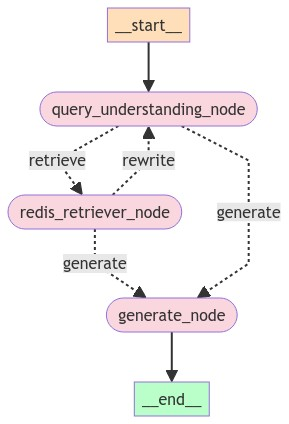

In [60]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("query_understanding_node", query_understanding)
workflow.add_node("redis_retriever_node", redis_retriever)
workflow.add_node("generate_node", generate)

# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retriever_node",
    check_retrieval_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "query_understanding_node",
        "generate": "generate_node",
    },
)


workflow.add_conditional_edges(
    "query_understanding_node",
    check_question_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "retrieve": "redis_retriever_node",
        "generate": "generate_node",
    },
)


workflow.add_edge("generate_node", END)

workflow.set_entry_point("query_understanding_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display
try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


In [61]:
import pprint

inputs = {
    "input":"What was the deferred revenue of aapl in 2022?",
}
for output in graphapp.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

--- QUERY Analysis ---
---QUERY rewrite---question_analysis={'question_class': 'earning_call', 'new_question': "What was Apple's revenue in 2022?", 'question_type': 'numeric', 'question_relevancy': 'relevant'}
---Question Class: Question is Related to earning_call---
---Question Analysis: alternate_question is What was Apple's revenue in 2022?---
"Output from node 'query_understanding_node':"
'---'
{ 'alternate_question': "What was Apple's revenue in 2022?",
  'filters': '@doc_type:{earning_call} AND (@ticker:{AAPL})',
  'question_class': 'earning_call',
  'question_note': None,
  'question_relevancy': 'relevant',
  'question_type': 'numeric',
  'rewrite_num': 1}
'\n---\n'
---RETRIEVE FROM REDIS---
	---RETRIEVE FROM REDIS= query=What was the deferred revenue of aapl in 2022? alternate_question=What was Apple's revenue in 2022?- retries=1
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Output fr

In [62]:
import pprint

inputs2 = {
    "input":"Why colorless green ideas are furiously sleeping?"
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        pprint.pprint(f"Output from node '{key2}':")
        pprint.pprint("---")
        pprint.pprint(value2, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

--- QUERY Analysis ---
---QUERY rewrite---question_analysis={'question_class': 'earning_call', 'new_question': "What was Apple's revenue in 2022?", 'question_type': 'numeric', 'question_relevancy': 'relevant'}
---Question Class: Question is Related to earning_call---
---Question Analysis: alternate_question is What was Apple's revenue in 2022?---
"Output from node 'query_understanding_node':"
'---'
{ 'alternate_question': "What was Apple's revenue in 2022?",
  'filters': '@doc_type:{earning_call}',
  'question_class': 'earning_call',
  'question_note': None,
  'question_relevancy': 'relevant',
  'question_type': 'numeric',
  'rewrite_num': 1}
'\n---\n'
---RETRIEVE FROM REDIS---
	---RETRIEVE FROM REDIS= query=Why colorless green ideas are furiously sleeping? alternate_question=What was Apple's revenue in 2022?- retries=1
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Output from node 'redis_ret

![furiously_sleeping](chomsky.png)

In [63]:
inputs2 = {
    "input":"What was the summary of aapl financial data presented in july 2020 earning calls?"
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        pprint.pprint(f"Output from node '{key2}':")
        pprint.pprint("---")
        pprint.pprint(value2, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

--- QUERY Analysis ---
---QUERY rewrite---question_analysis={'question_class': 'earning_call', 'new_question': "What was Apple's revenue in 2022?", 'question_type': 'numeric', 'question_relevancy': 'relevant'}
---Question Class: Question is Related to earning_call---
---Question Analysis: alternate_question is What was Apple's revenue in 2022?---
"Output from node 'query_understanding_node':"
'---'
{ 'alternate_question': "What was Apple's revenue in 2022?",
  'filters': '@doc_type:{earning_call} AND (@ticker:{AAPL})',
  'question_class': 'earning_call',
  'question_note': None,
  'question_relevancy': 'relevant',
  'question_type': 'numeric',
  'rewrite_num': 1}
'\n---\n'
---RETRIEVE FROM REDIS---
	---RETRIEVE FROM REDIS= query=What was the summary of aapl financial data presented in july 2020 earning calls? alternate_question=What was Apple's revenue in 2022?- retries=1
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: 

We have certainly indexed this data but failed to retrieve. A date NER and and `source_year` filter translation will fix this!   

## Next Steps
Implement
- Multiple index routing scenarios where based on the detected `query_class` we run retrieval queries on different Redis indices.
- Implement a Caching strategy using powerful and superfast Redis features, including `SemanticCache`.
- Replace the `RelevancyGrader` by a proper reranking model and node.   

## Conclusion
The problem of search is still an old problem, and it is about representation of your information and storing it and getting back what you search for via a retrieval method. In the new `RAG` paradigm, information representation is the vector representation. So the more you can capture the nuances of your data using better and better embedding models, the better the `Retrieval`. However, as demonstrated above, we still need to take advantage of our metadata to increase the accuracy and `Augment` the query and also augment the context that we present to the `Generation` component. And most recently, LLMs do a good job of generating proper answers in the target natural languages. The quality of LLMs and their awareness of the domain language increase the quality of generated response.   